In [1]:
import ultralytics
from ultralytics import YOLO

In [33]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import os
import sys
import cv2
import numpy as np

import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import matplotlib.patches as patches


sys.path.append('../..')
from w2.xai.eigen_cam import EigenCAM


In [3]:
def show_cam_on_image(img: np.ndarray,
                      mask: np.ndarray,
                      use_rgb: bool = False,
                      colormap: int = cv2.COLORMAP_JET,
                      image_weight: float = 0.5) -> np.ndarray:
    """ This function overlays the cam mask on the image as an heatmap.
    By default the heatmap is in BGR format.

    :param img: The base image in RGB or BGR format.
    :param mask: The cam mask.
    :param use_rgb: Whether to use an RGB or BGR heatmap, this should be set to True if 'img' is in RGB format.
    :param colormap: The OpenCV colormap to be used.
    :param image_weight: The final result is image_weight * img + (1-image_weight) * mask.
    :returns: The default image with the cam overlay.
    """
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), colormap)
    if use_rgb:
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = np.float32(heatmap) / 255

    if np.max(img) > 1:
        raise Exception(
            "The input image should np.float32 in the range [0, 1]")

    if image_weight < 0 or image_weight > 1:
        raise Exception(
            f"image_weight should be in the range [0, 1].\
                Got: {image_weight}")

    cam = (1 - image_weight) * heatmap + image_weight * img
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

In [11]:
model_path = 'weights/yolov8s-best.pt'

# Model is loaded using ultralytics YOLO wrapper
model = YOLO(model_path).model
target_layers = [model.model[-7]]

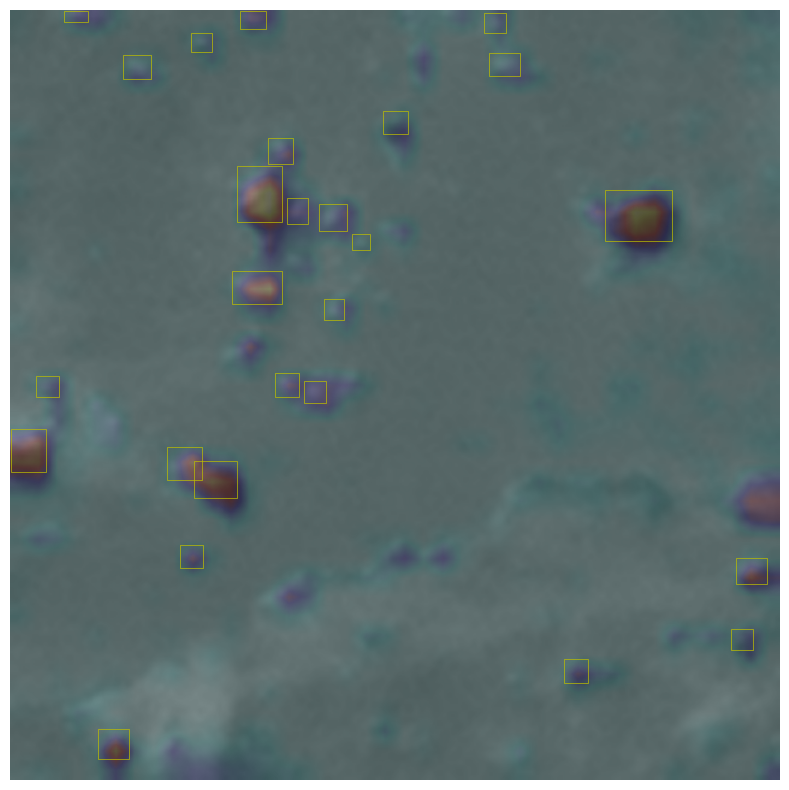

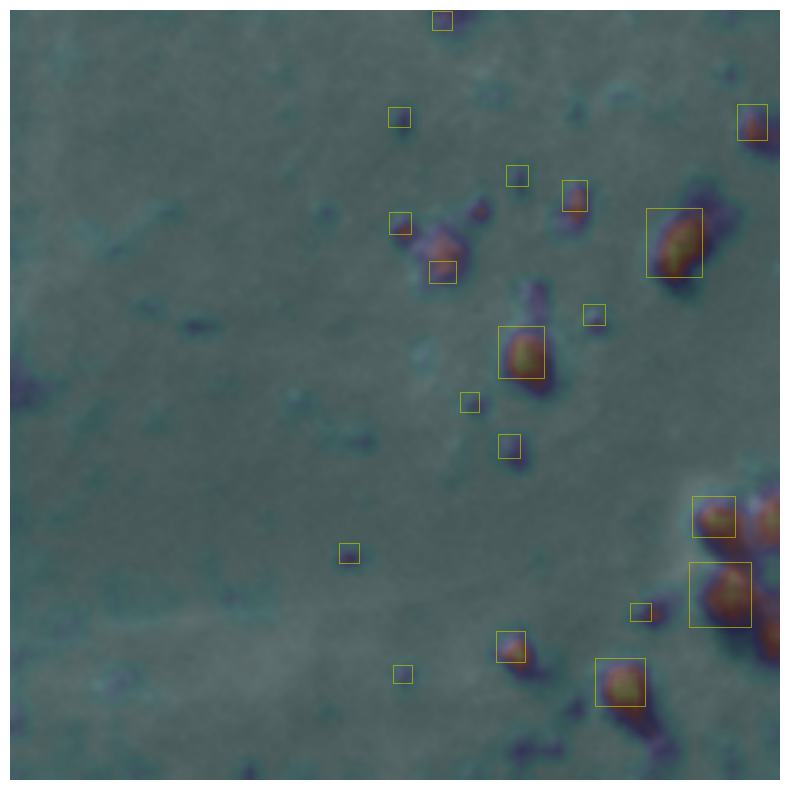

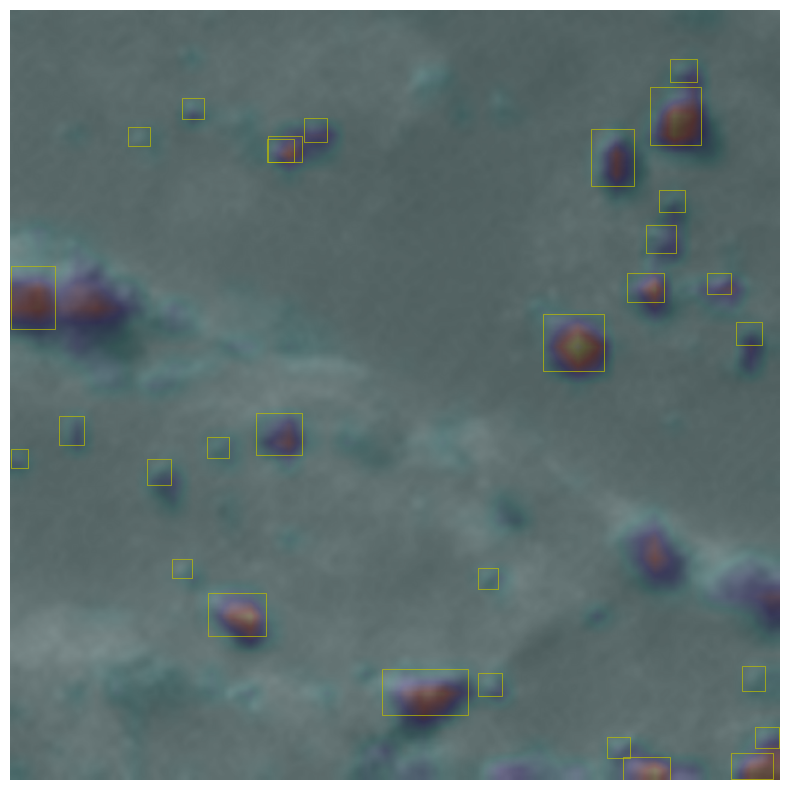

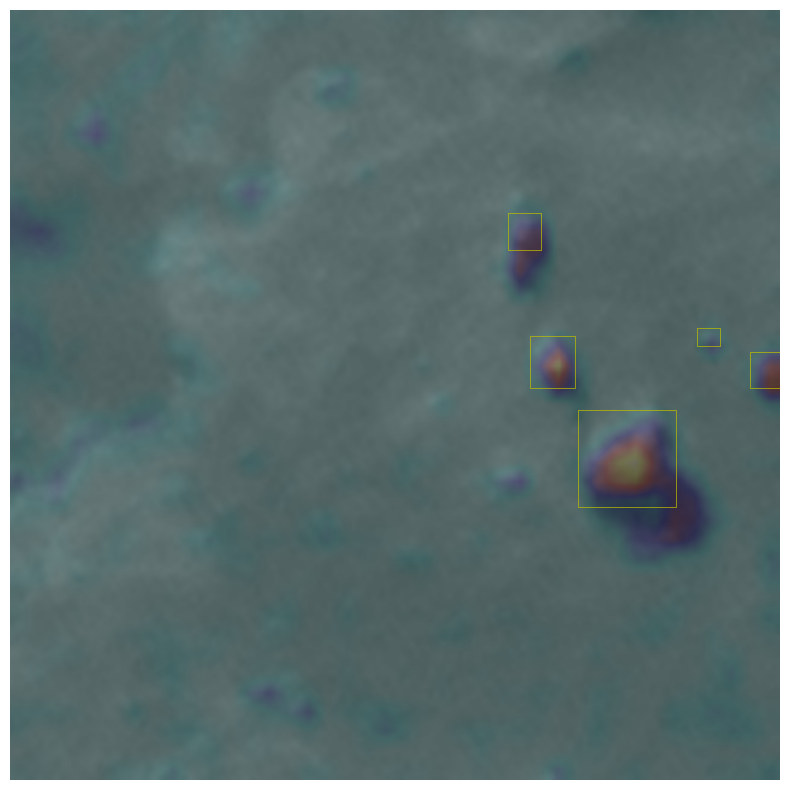

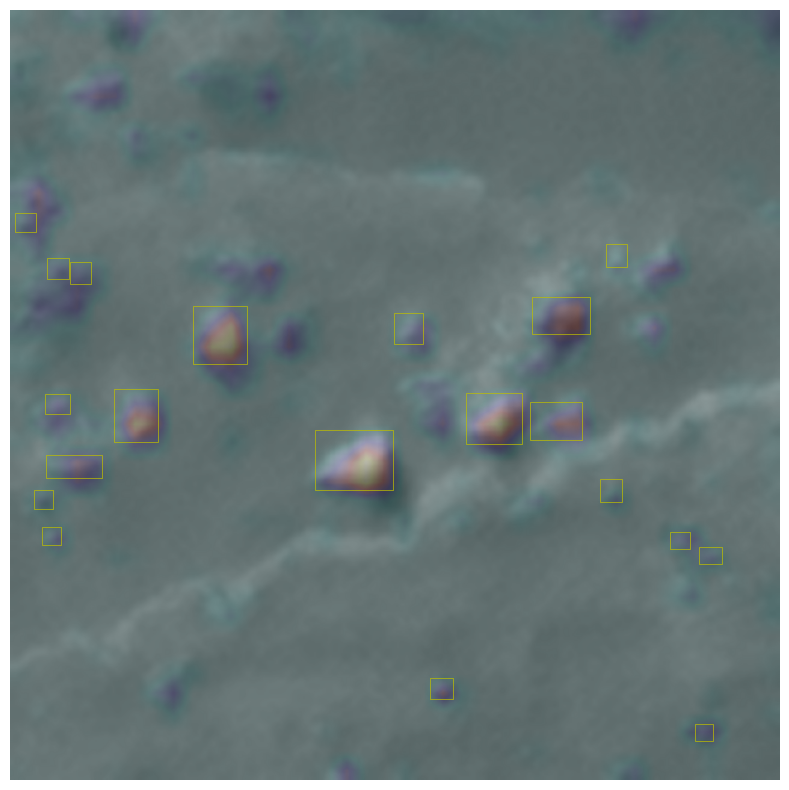

In [68]:
save_plot = False
for lbl in os.listdir('test_images/labels'):
    
    with open('test_images/labels/' + lbl, 'r') as f:
        lbls = f.read().splitlines()
    lbls = [l.split()[1:] for l in lbls]
    bboxs = []
    rez = 640
    for bbox in lbls:
        bbox = [float(b) for b in bbox]
        width = bbox[2]*rez
        height = bbox[3]*rez
        x = bbox[0]*rez - width/2
        y = bbox[1]*rez - height/2
        bboxs.append([x, y, width, height])

    img = cv2.imread(f'test_images/{lbl.replace("txt", "png")}')
    img = np.float32(img) / 255
    transform = transforms.ToTensor()
    tensor = transform(img).unsqueeze(0).cpu()

    cam = EigenCAM(model, target_layers, use_cuda=False)
    grayscale_cam = cam(tensor, targets = [0])[0, :, :]
    cam_image = 255 - show_cam_on_image(img, grayscale_cam)
    
    # Create figure and axes
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.axis('off')
    plt.margins(0,0)

    # Display the image
    ax.imshow(img)
    ax.imshow(cam_image, alpha = 0.2, cmap='jet')
    for bbox in bboxs:
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=0.5, edgecolor='y', facecolor='none')
        ax.add_patch(rect)

    if save_plot == True:
        plt.savefig(f'results/{lbl.split(".")[0]}_box_cam.png', bbox_inches='tight', pad_inches=0)